In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
# Vision transformer link
# https://keras.io/examples/vision/image_classification_with_vision_transformer/

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math, gc, warnings, scipy, random, os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

EPOCHS = 200
BATCH_SIZE = 32
IMG_SIZE = (208, 176)
SEED = 100
CLASSES = 4
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    }),
    total_num_examples=13174,
    splits={
        'test': 1279,
        'train': 5329,
        'train2': 6566,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



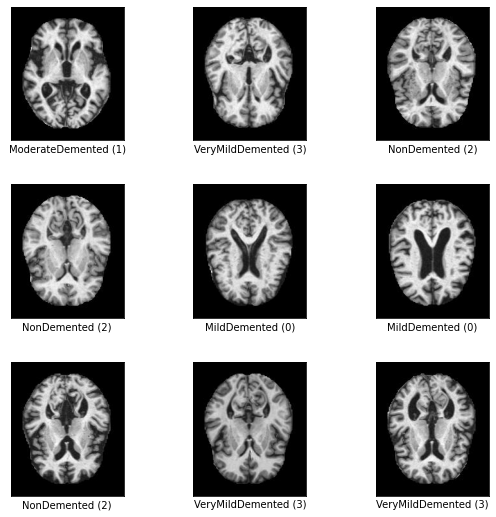

In [ ]:
builder = tfds.ImageFolder("drive/MyDrive/Alzheimer_Dataset/")
print(builder.info)  
ds_info = builder.info
ds_train = builder.as_dataset(split='train2', shuffle_files=True,as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True,as_supervised=True)
fig = tfds.show_examples(ds_train, builder.info)

In [ ]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    return 2*(image - 0.5), tf.one_hot(label, depth = 4)
    
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        y_true_K = K.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(208,176,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 42, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 50, 42, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 20, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 20, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 20, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
actual_model=tf.keras.models.Sequential()
actual_model.add(model)
actual_model.add(tf.keras.layers.Flatten())
actual_model.add(tf.keras.layers.Dense(512,activation=('relu')))
actual_model.add(tf.keras.layers.Dense(256,activation=('relu'))) 
actual_model.add(tf.keras.layers.Dense(128,activation=('relu')))
actual_model.add(tf.keras.layers.Dense(4, activation="softmax"))


In [ ]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 

    The graph is updated by the 'on_epoch_end' event of the Keras Callback class

    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 

    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch

    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title

    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        plt.figure()

        plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)







In [ ]:
print(ds_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [ ]:
from keras import backend as K
loss = tf.losses.CategoricalCrossentropy()
# loss = focal_loss_custom(0.2,0.5)
optim = tf.keras.optimizers.Adam(learning_rate=1e-6)
# plotter = ConfusionMatrixPlotter(ds_test[0],ds_test[1],{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names})
metrics = ["accuracy"]
model.compile(loss=loss , optimizer=optim, metrics=metrics)
m1=model.fit(ds_train, validation_data=ds_test, epochs=500, verbose=2)

Epoch 1/500
167/167 - 8s - loss: 2.6596 - accuracy: 0.3381 - val_loss: 1.3102 - val_accuracy: 0.5004 - 8s/epoch - 48ms/step
Epoch 2/500
167/167 - 6s - loss: 2.4538 - accuracy: 0.3492 - val_loss: 1.2520 - val_accuracy: 0.5004 - 6s/epoch - 38ms/step
Epoch 3/500
167/167 - 6s - loss: 2.2731 - accuracy: 0.3674 - val_loss: 1.2102 - val_accuracy: 0.5004 - 6s/epoch - 39ms/step
Epoch 4/500
167/167 - 7s - loss: 2.1614 - accuracy: 0.3689 - val_loss: 1.1888 - val_accuracy: 0.5004 - 7s/epoch - 39ms/step
Epoch 5/500
167/167 - 6s - loss: 2.0865 - accuracy: 0.3646 - val_loss: 1.1754 - val_accuracy: 0.5004 - 6s/epoch - 39ms/step
Epoch 6/500
167/167 - 6s - loss: 1.9666 - accuracy: 0.3751 - val_loss: 1.1668 - val_accuracy: 0.5004 - 6s/epoch - 39ms/step
Epoch 7/500
167/167 - 6s - loss: 1.8677 - accuracy: 0.3787 - val_loss: 1.1682 - val_accuracy: 0.5004 - 6s/epoch - 39ms/step
Epoch 8/500
167/167 - 6s - loss: 1.8494 - accuracy: 0.3746 - val_loss: 1.1613 - val_accuracy: 0.5004 - 6s/epoch - 39ms/step
Epoch 9/

In [ ]:
preds=model.predict(ds_test)

In [ ]:
y = np.concatenate([y for x, y in ds_test], axis=0)
tf.math.confusion_matrix(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 43,   5,  59,  72],
       [  2,   4,   3,   3],
       [ 15,   1, 481, 143],
       [ 25,   8, 195, 220]], dtype=int32)>

In [ ]:
!pip install pretty-confusion-matrix


     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 11.2 MB 7.8 MB/s 
     |████████████████████████████████| 156 kB 72.6 MB/s 
     |████████████████████████████████| 103 kB 76.3 MB/s 
     |████████████████████████████████| 197 kB 90.1 MB/s 
     |████████████████████████████████| 843 kB 69.0 MB/s 
     |████████████████████████████████| 41 kB 746 kB/s 
     |████████████████████████████████| 68 kB 8.7 MB/s 
     |████████████████████████████████| 899 kB 60.8 MB/s 
     |████████████████████████████████| 98 kB 9.8 MB/s 
     |████████████████████████████████| 8.8 MB 57.9 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
     |████████████████████████████████| 461 kB 73.4 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:


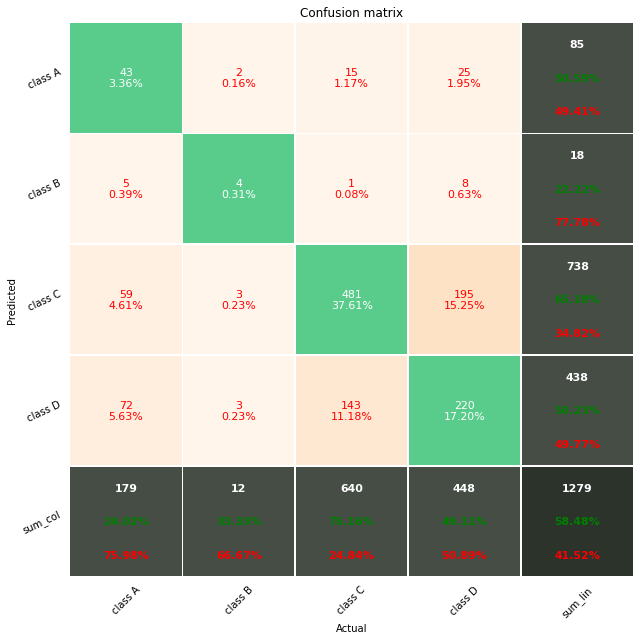

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
pp_matrix_from_data(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))
